In [1]:
# Import necessary libraries
import sys
sys.path.insert(0, "..\\..\\")  # add the parent directory to path
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import librosa
import librosa.display
from sklearn.svm import OneClassSVM
from sklearn import metrics
import plotly.express as px
import pickle

from utils.get_mel_spectrogram import get_mel_spectrogram
from utils.get_melspec_features_from_files import get_melspec_features_from_files
from utils.confusion_metrics import confusion_metrics
from utils.train_test_one_class_svm import train_test_one_class_svm
from utils.get_train_test_data import get_train_test_data
from utils.add_train_test_labels_to_dataframe import add_train_test_labels_to_dataframe

In [2]:
# Directories
parent_dir = os.path.abspath('..\\..\\')  # main directory
# Audio data directory
data_dir = os.path.join(parent_dir, 'data', 'source')  # audio data directory
# Metada directory
metadata_dir = os.path.join(parent_dir, 'data', 'metadata')  # metadata directory

In [3]:
# Read the metadata file
df = pd.read_csv(os.path.join(metadata_dir, 'metadata.csv'), header=0, index_col=0)
df

,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB
file_no,,,,,,,,
0,fan,0,1,00000000.wav,6_dB_fan\fan\id_00\abnormal\00000000.wav,10.0,16000,6
1,fan,0,1,00000001.wav,6_dB_fan\fan\id_00\abnormal\00000001.wav,10.0,16000,6
2,fan,0,1,00000002.wav,6_dB_fan\fan\id_00\abnormal\00000002.wav,10.0,16000,6
3,fan,0,1,00000003.wav,6_dB_fan\fan\id_00\abnormal\00000003.wav,10.0,16000,6
4,fan,0,1,00000004.wav,6_dB_fan\fan\id_00\abnormal\00000004.wav,10.0,16000,6
...,...,...,...,...,...,...,...,...
18014,valve,6,0,00000987.wav,6_dB_valve\valve\id_06\normal\00000987.wav,10.0,16000,6
18015,valve,6,0,00000988.wav,6_dB_valve\valve\id_06\normal\00000988.wav,10.0,16000,6
18016,valve,6,0,00000989.wav,6_dB_valve\valve\id_06\normal\00000989.wav,10.0,16000,6


In [4]:
# Randomly select a subset of samples for a single machine
machine = 'fan'
df_machine = df[df.machine=='fan']

df_machine = df_machine.groupby(["model", "anomaly"]).sample(frac=0.6, random_state=13)
df_machine.groupby(["model", "anomaly"])['file_name'].count().reset_index(name='count')

,model,anomaly,count
0,0,0,607
1,0,1,244
2,2,0,610
3,2,1,215
4,4,0,620
5,4,1,209
6,6,0,609
7,6,1,217


{'window': 0.5, 'window_length': 8000, 'overlap': 0.25, 'overlap_length': 2000, 'hop_length': 6000, 'n_fft': 8192, 'n_mels': 64, 'fmin': 0, 'fmax': 8000.0, 'mel_center_freq': array([  46.875   ,   93.75    ,  138.671875,  185.546875,  232.421875,
        279.296875,  324.21875 ,  371.09375 ,  417.96875 ,  464.84375 ,
        509.765625,  556.640625,  603.515625,  650.390625,  695.3125  ,
        742.1875  ,  789.0625  ,  835.9375  ,  880.859375,  927.734375,
        974.609375, 1021.484375, 1072.265625, 1125.      , 1179.6875  ,
       1238.28125 , 1298.828125, 1361.328125, 1427.734375, 1498.046875,
       1572.265625, 1648.4375  , 1730.46875 , 1814.453125, 1904.296875,
       1996.09375 , 2095.703125, 2197.265625, 2304.6875  , 2417.96875 ,
       2537.109375, 2660.15625 , 2791.015625, 2927.734375, 3072.265625,
       3222.65625 , 3380.859375, 3546.875   , 3720.703125, 3902.34375 ,
       4093.75    , 4294.921875, 4503.90625 , 4726.5625  , 4957.03125 ,
       5201.171875, 5455.078125, 

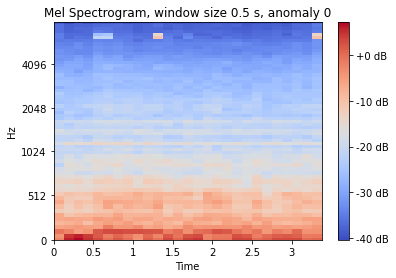

In [5]:
# Compute and plot mel spectrogram
no_file = 2
file_path = os.path.join(data_dir, df_machine.iloc[no_file].file_rel_path)
fs = df_machine.iloc[no_file].fs_Hz
window = 0.5 # 2
n_mels = 64
mel_spect, mel_spect_db, mfcc, params = get_mel_spectrogram(file_path, window=window, overlap=0.25, n_mels=n_mels, machine='pump') 

print(params)

print(f"Size of mel_spect: {mel_spect.shape}, total number of points: {mel_spect.size}")
librosa.display.specshow(mel_spect_db, sr=fs, hop_length=params['overlap_length'], x_axis='time', y_axis='mel');

plt.title(f"Mel Spectrogram, window size {params['window']} s, anomaly {df_machine.iloc[no_file].anomaly}");
plt.colorbar(format='%+2.0f dB');

array([  46.875   ,   93.75    ,  138.671875,  185.546875,  232.421875,
        279.296875,  324.21875 ,  371.09375 ,  417.96875 ,  464.84375 ,
        509.765625,  556.640625,  603.515625,  650.390625,  695.3125  ,
        742.1875  ,  789.0625  ,  835.9375  ,  880.859375,  927.734375,
        974.609375, 1021.484375, 1072.265625, 1125.      , 1179.6875  ,
       1238.28125 , 1298.828125, 1361.328125, 1427.734375, 1498.046875,
       1572.265625, 1648.4375  , 1730.46875 , 1814.453125, 1904.296875,
       1996.09375 , 2095.703125, 2197.265625, 2304.6875  , 2417.96875 ,
       2537.109375, 2660.15625 , 2791.015625, 2927.734375, 3072.265625,
       3222.65625 , 3380.859375, 3546.875   , 3720.703125, 3902.34375 ,
       4093.75    , 4294.921875, 4503.90625 , 4726.5625  , 4957.03125 ,
       5201.171875, 5455.078125, 5722.65625 , 6003.90625 , 6296.875   ,
       6605.46875 , 6929.6875  , 7269.53125 , 7626.953125])

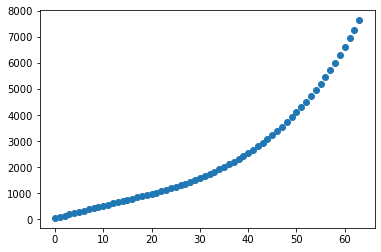

In [6]:
# Centers of mel frequency bands
plt.scatter(range(len(params['mel_center_freq'])), params['mel_center_freq'])
params['mel_center_freq']

In [7]:
window = 0.5
n_mels = 64
overlap = 0.25

X, y, params = get_melspec_features_from_files(data_dir, df_machine, window, n_mels, overlap)
print(X.shape)
print(y.shape)

(3331, 1728)
(3331, 1)


In [8]:
# Add labels for training and test
df_machine = add_train_test_labels_to_dataframe(df_machine, no_seed=12)

In [9]:
# Get training and test samples
X_train, X_test, y_train, y_test = get_train_test_data(X, y, df_machine)

(array([  8.,  30.,  93., 137., 250., 375., 293., 225., 129.,  21.]),
 array([-17.61065   , -15.133265  , -12.65588   , -10.178495  ,
         -7.701111  ,  -5.2237263 ,  -2.7463417 ,  -0.26895714,
          2.2084274 ,   4.685812  ,   7.1631966 ], dtype=float32),
 <BarContainer object of 10 artists>)

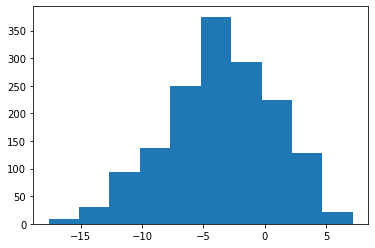

In [10]:
# Histogram of features
plt.hist(X_train[:,10])

In [11]:
# One class svm 
gamma = 0.01
nu = 0.01
prctle = 2
out_class = train_test_one_class_svm(X_train, X_test, y_train, y_test, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


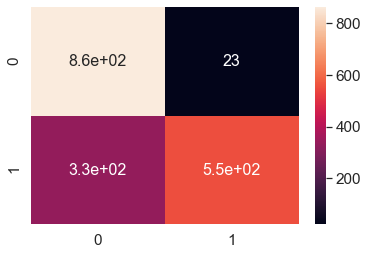

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       885
           1       0.96      0.62      0.76       885

    accuracy                           0.80      1770
   macro avg       0.84      0.80      0.79      1770
weighted avg       0.84      0.80      0.79      1770



In [13]:
cm_plot = out_class[3]
df_cm = pd.DataFrame(cm_plot, range(cm_plot.shape[0]), range(cm_plot.shape[1]))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

print(out_class[1])

In [ ]:
ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ran_prctl = range(1,15)
nu = 0.5
# Initialize arrays
out_metrics_gn = {}
out_metrics_gn['acc'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['precision']  = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['recall'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['TPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['FPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl):
        print(gamma, prctle)
        
        out_class = train_test_one_class_svm(X_train, X_test, y_train, y_test, 
                                     kernel='rbf', gamma=0.001, nu=0.5, prctle=2, normalize="min-max")
        # return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params
        
        out_metrics = out_class[5]
        out_metrics_gn['acc'][id_p, id_g] = out_metrics['acc']
        out_metrics_gn['precision'][id_p, id_g] = out_metrics['precision']
        out_metrics_gn['recall'][id_p, id_g] = out_metrics['recall']
        out_metrics_gn['TPR'][id_p, id_g] = out_metrics['TPR']
        out_metrics_gn['FPR'][id_p, id_g] = out_metrics['FPR']
        

0.0001 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0001 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.0005 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.001 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.005 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.01 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.05 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 9


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 10


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 11


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 12


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 13


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.1 14


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 1


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 2


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 3


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 4


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 5


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 6


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 7


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 8


C:\Users\ecebo\MyRepos\AudioMalfunctionDetection\Modeling\One-class SVM\..\..\utils\confusion_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))


0.5 9


0.01


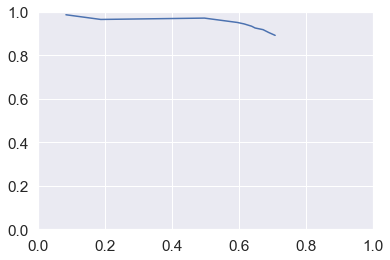

In [245]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g==4):
        print(gamma)
        plt.plot(recall_gn[:, id_g], precision_gn[:, id_g])
        plt.xlim([0, 1])
        plt.ylim([0, 1])
plt.show()

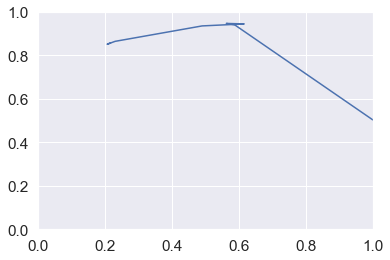

In [249]:
for id_p, prctl in enumerate(ran_prctl):
    if(id_p==4):
        plt.plot(recall_gn[id_p, :], precision_gn[id_p, :])
        plt.xlim([0, 1])
        plt.ylim([0, 1])
plt.show()

0.01


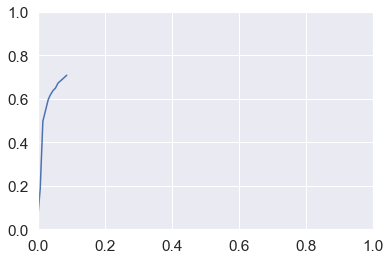

In [253]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g==4):
        print(gamma)
        plt.plot(FPR_gn[:, id_g], TPR_gn[:, id_g])
        plt.xlim([0, 1])
        plt.ylim([0, 1])
plt.show()

In [255]:
id_p = 9
id_g = 4
print("precision: ", precision_gn[id_p, id_g])
print("recall: ", recall_gn[id_p, id_g])

precision:  0.8918918918918919
recall:  0.7084745762711865


In [19]:
# Select all abnormal samples as test, equal number of normal also in test, rest in training
df_machine_all = df[df.machine=='fan']

window = 0.5
n_mels = 64
overlap = 0.25

X_all, y_all, params_all = get_melspec_features_from_files(data_dir, df_machine_all, window, n_mels, overlap)

# Add labels for training and test
df_machine_all = add_train_test_labels_to_dataframe(df_machine_all, no_seed=30)

# Get training and test samples
X_train_all, X_test_all, y_train_all, y_test_all = get_train_test_data(X, y, df_machine_all)

# One class svm 
id_p = 9
# id_g = 4
prctl = ran_prctl[id_p]
# gamma = ran_gamma[id_g]
nu = 0.5
out_class = train_test_one_class_svm(X_train, X_test, y_train, y_test, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

KeyboardInterrupt: 

In [ ]:
ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ran_prctl_selected = 7 # range(0,15)
nu = 0.5
# Initialize arrays
out_metrics_all_gn = {}
out_metrics_all_gn['acc'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['precision']  = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['recall'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['TPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['FPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl_selected):
        
        out_class = train_test_one_class_svm(X_train_all, X_test_all, y_train_all, y_test_all, 
                                     kernel='rbf', gamma=0.001, nu=0.5, prctle=2, normalize="min-max")
        # return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params
        
        out_metrics = out_class[5]
        out_metrics_all_gn['acc'][id_p, id_g] = out_metrics['acc']
        out_metrics_all_gn['precision'][id_p, id_g] = out_metrics['precision']
        out_metrics_all_gn['recall'][id_p, id_g] = out_metrics['recall']
        out_metrics_all_gn['TPR'][id_p, id_g] = out_metrics['TPR']
        out_metrics_all_gn['FPR'][id_p, id_g] = out_metrics['FPR']
        

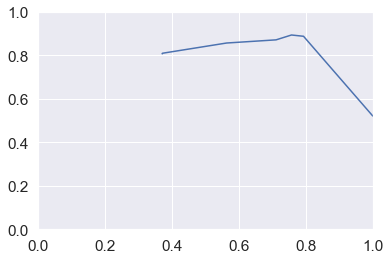

In [313]:
# Precision and recall
plt.plot(recall_gamma_all, precision_gamma_all)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [320]:
# Metrics for the previously chosen gamma and prctle
prctl = 4
gamma = 0.01
out_class = train_test_one_class_svm(X_train_all, X_test_all, y_train_all, y_test_all, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

In [331]:
cm_test

array([[1320,  155],
       [ 426, 1049]], dtype=int64)

In [332]:
out_metrics_test_all

{'acc': 0.8030508474576271,
 'precision': 0.8712624584717608,
 'recall': 0.7111864406779661,
 'sensitivity': 0.7111864406779661,
 'specificity': 0.8949152542372881,
 'TPR': 0.7111864406779661,
 'FPR': 0.10508474576271187,
 'f1': 0.7831280328480776}

In [333]:
cm_train

array([[2366,  234],
       [   0,    0]], dtype=int64)

In [334]:
out_metrics_train_all

{'acc': 0.90999999965,
 'precision': 0.0,
 'recall': 0.0,
 'sensitivity': 0.0,
 'specificity': 0.91,
 'TPR': 0.0,
 'FPR': 0.08999999999999997,
 'f1': nan}